# 训练分类器

## 关于数据？

通常，当处理图像、文本、音频或视频数据时，你可以使用标准的 Python 包将数据装载到 numpy 数组中。然后可以将该数组转换为 torch.*Tensor.

- 图像：Pillow、OpenCV
- 音频：scipy、librosa
- 文本：原始 Python、Cython、NLTK、SpaCy

特别地对于视觉，我们创建了一个名为 torchvision 的软件包，它包含用于常见数据集的数据加载器，如 Imagenet，CIFAR10，MNIST 等，以及用于图像的数据转换器，即 torchvision.datasets 和 torch.utils.data.DataLoader.

这提供了极大的便利并避免编写冗余代码。

本教程中，使用 CIFAR10 数据集，其中有类 ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. CIFAR10 中的图像大小是 3x32x32，即 3 种颜色信息，32x32 像素的图片。

## 训练图像分类器

按序执行以下步骤：
1. 使用 torchvision 装载并标准化 CIFAR 10 的训练和测试数据集
2. 定义卷积神经网络
3. 定义损失函数
4. 使用训练数据训练网络
5. 使用测试数据测试网络

### 1. 装载并标准化  CIFAR 10 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 数据集的输出是范围 [0,1] 的 PILImage 图像。我们将它们转换为归一化范围的张量 [-1,1]。

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting tar file
Done!
Files already downloaded and verified


展示一些训练图像，为了玩。

 deer  ship plane truck


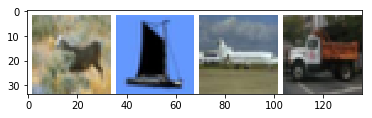

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 展示一个图像的函数


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 获取一些随机的训练图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 定义卷积神经网络

复制前一节“神经网络”的神经网络，并修改为 3 通道图像（而不是 1 通道图像）。

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 定义损失函数和优化器

使用分类交叉熵损失函数和带动量的随机梯度下降。

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

### 4. 训练网络

这是事情开始变得有趣的时候。我们只需循环遍历数据迭代器，并将输入提供给网络并进行优化。

In [8]:
for epoch in range(2):  # 多次循环遍历数据集

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data

        # 清零参数梯度
        optimizer.zero_grad()

        # 前向 + 反向 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 输出统计
        running_loss += loss.item()
        if i % 2000 == 1999:    # 打印每个 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 1.833
[1,  6000] loss: 1.674
[1,  8000] loss: 1.592
[1, 10000] loss: 1.550
[1, 12000] loss: 1.477
[2,  2000] loss: 1.425
[2,  4000] loss: 1.397
[2,  6000] loss: 1.370
[2,  8000] loss: 1.371
[2, 10000] loss: 1.303
[2, 12000] loss: 1.306
Finished Training


### 5. 使用测试数据测试网络

我们已经在训练数据集上训练了2次。 但我们需要检查网络是否已经学到了什么。

我们将通过预测神经网络输出的类标签来检查这一点，并根据真实情况进行检查。 如果预测正确，我们将样本添加到正确预测列表中。

好的，第一步。让我们从测试集中显示一个图像以熟悉。

GroundTruth:    cat  ship  ship plane


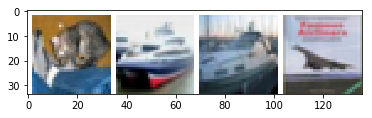

In [9]:
detaiter = iter(testloader)
images, labels = detaiter.next()

# 打印图像
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

好的，现在让我们看看神经网络认为上面这些例子是什么：

In [13]:
outputs = net(images)

输出是10个类的能量。 一个类的能量越高，网络认为图像更可能属于该类。 那么，让我们得到最高能量的指数：

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


让我们看看网络如何在整个数据集上执行。

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


这个准确率比瞎猜好一些，瞎猜的准确率是10%，看来网络学到了一些东西。

各类的准确率：

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 50 %
Accuracy of  bird : 35 %
Accuracy of   cat : 14 %
Accuracy of  deer : 39 %
Accuracy of   dog : 50 %
Accuracy of  frog : 80 %
Accuracy of horse : 64 %
Accuracy of  ship : 76 %
Accuracy of truck : 68 %


## GPU 上训练

就像你将Tensor转移到GPU上一样，你将神经网络转移到GPU上。

如果我们有可用的CUDA，我们首先将我们的设备定义为第一个可见的cuda设备：

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 假设我们在一台 CUDA 设备上运行，那么这该打印一个 CUDA 设备

print(device)

cpu


本节的其余部分假定设备是 CUDA 设备。

然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为 CUDA 张量：

In [18]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，您还必须将每一步的输入和目标发送到 GPU：

In [20]:
inputs, labels = inputs.to(device), labels.to(device)

为什么我不注意与 CPU 相比的 MASSIVE 加速？ 因为你的网络很小。